# Spam Email Classifier - Naive Bayes

In this project, I will be exploring the classification of spam emails and how they can be caught using spam filters. Naive Bayes can be used to calculate the probability of an email being ham or spam based on the indvidual words used and their respective probabilities to be found in a ham or spam email.

The Naive Bayes implementation will be coded from scratch however it is also possible to use a pre-packaged implementation within the likes of Scikit learn.

The Enron dataset used in this project can be found on [Kaggle](https://www.kaggle.com/datasets/nitishabharathi/email-spam-dataset).

## Importing Data

In [ ]:
import pandas as pd
import re
import numpy as np

data = pd.read_csv('enronSpamSubset.csv')
data.head()

,Unnamed: 0.1,Unnamed: 0,Body,Label
0,2469,2469,Subject: stock promo mover : cwtd\n * * * urge...,1
1,5063,5063,Subject: are you listed in major search engine...,1
2,12564,12564,"Subject: important information thu , 30 jun 20...",1
3,2796,2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,1468,1468,"Subject: "" bidstogo "" is places to go , things...",1


After reading in the dataset and taking a look at the first few rows, I can see that there are two columns beginning `Unnamed` that aren't useful. They appear to be some kind of identifier but are redundant for what I'm looking at. I will remove them from the dataframe.

In [ ]:
data.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)
data.head()

,Body,Label
0,Subject: stock promo mover : cwtd\n * * * urge...,1
1,Subject: are you listed in major search engine...,1
2,"Subject: important information thu , 30 jun 20...",1
3,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,"Subject: "" bidstogo "" is places to go , things...",1


Now I'm left with the `Body` and `Label` columns.
`Body` contains the contents of the emails and this is the feature I will be basing the classifier around.
`Label` is the target and this returns `1` if the email is spam and `0` if the email is ham.

Next I will look to remove any duplicate entries, important for calculating the word frequencies later, and also any missing values (if there are any).

In [ ]:
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
data.shape

(9687, 2)

After removing those I can see that the data consists of the 2 columns along with 9687 rows - each corresponding to a different email.

In [ ]:
data['Label'].value_counts(normalize=True)

0    0.50862
1    0.49138
Name: Label, dtype: float64

It's not everyday that you get a balanced dataset but in this case 51% are ham and 49% are spam.

## Text Cleaning

Now the Naive Bayes classifier that I'm developing will be focusing on the frequency of words in the email dataset. Before I get to this stage, I want to perform some data cleaning to ensure the email contents are in a state that can be easily analysed.

I'll begin by defining a list of stopwords. Stopwords are the really common words that appear in everyday life such as "a", "because" and "the". If I can filter these out from the email contents, it will help to eliminate some of the noise and focus more on the context-specific words.

I've found a list of English stopwords from the following [website](https://www.ranks.nl/stopwords). I will add them to a list and also manually include "subject" and "re" as both are email related and both appear very frequently.

In [ ]:
stop_words = ["a","about","above","after","again","against","all","am","an","and","any","are","aren't","as","at","be","because",
              "been","before","being","below","between","both","but","by","can't","cannot","could","couldn't","did","didn't","do",
              "does","doesn't","doing","don't","down","during","each","few","for","from","further","had","hadn't","has","hasn't",
              "have","haven't","having","he","he'd","he'll","he's","her","here","here's","hers","herself","him","himself","his",
              "how","how's","i","i'd","i'll","i'm","i've","if","in","into","is","isn't","it","it's","its","itself","let's","me",
              "more","most","mustn't","my","myself","no","nor","not","of","off","on","once","only","or","other","ought","our","ours",
              "ourselves","out","over","own","re","same","shan't","she","she'd","she'll","she's","should","shouldn't","so","some",
              "subject","such","than","that","that's","the","their","theirs","them","themselves","then","there","there's","these",
              "they","they'd","they'll","they're","they've","this","those","through","to","too","under","until","up","very","was",
              "wasn't","we","we'd","we'll","we're","we've","were","weren't","what","what's","when","when's","where","where's","which",
              "while","who","who's","whom","why","why's","with","won't","would","wouldn't","you","you'd","you'll","you're","you've",
              "your","yours","yourself","yourselves"]

In order to perform some general string cleaning, I will define a `clean_text` function that will do the following:
- Convert to lowercase
- Remove non-word characters such as punctuation
- Remove any single letters
- Remove any single numerical digits
- Filter out the words listed in `stop_words`

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+\d\s+', ' ', text)
    tokens = text.split()
    text = [word for word in tokens if not word in stop_words]
    return ' '.join(text)

Now that I've defined the function, I will apply it to the `Body` column of the data and overwrite what is currently present.

In [ ]:
data['Body'] = data['Body'].apply(clean_text)
data.head()

,Body,Label
0,stock promo mover cwtd urgent investor trading...,1
1,listed major search engines submitting website...,1
2,important information thu 30 jun 2005 importan...,1
3,utf bask life utf individual incremen utf t in...,1
4,bidstogo places go things hello privacy policy...,1


## Training/Test Groups

I can now split the data up into two groups: training and test.
I will use an 80:20 split respectively.

In [ ]:
train_data = data.sample(frac=0.8, random_state=9)
test_data = data.drop(train_data.index)

In [ ]:
train_data['Label'].value_counts(normalize=True)

0    0.506323
1    0.493677
Name: Label, dtype: float64

In [ ]:
test_data['Label'].value_counts(normalize=True)

0    0.517811
1    0.482189
Name: Label, dtype: float64

Above I can see that the two new groups are both balanced and similar to the original 51:49 split in favour of ham emails.

The new `train_data` group needs to be split into separate ham and spam groups to make it easier to calculate the word frequencies for each group.

I can filter via boolean indexes around the `Label` column; saving anything with `0` into `ham_train` and anything with `1` into `spam_train`.

In [ ]:
ham_train = train_data[train_data['Label'] == 0]
spam_train = train_data[train_data['Label'] == 1]

## Calculating Word Frequencies

The word frequencies for both groups needs to be calculated.

I create two dictionaries to hold the word frequencies: `ham_word_freq` and `spam_word_freq`. I will then loop over the emails and words in both `ham_train` and `spam_train`, updating the respective frequency dictionaries.

In [ ]:
ham_word_freq = {}
spam_word_freq = {}

for email in ham_train['Body']:
  for word in email.split():
    ham_word_freq[word] = ham_word_freq.get(word, 0) + 1

for email in spam_train['Body']:
  for word in email.split():
    spam_word_freq[word] = spam_word_freq.get(word, 0) + 1

Below is the full `ham_word_freq` however I just browse the first few entries to make sure it has functioned correctly.

In [ ]:
ham_word_freq

{'ena': 572,
 'management': 893,
 'committee': 320,
 'reminder': 53,
 'will': 5836,
 'friday': 742,
 'meeting': 1094,
 'august': 365,
 '18': 517,
 '2000': 3056,
 'replaces': 11,
 'every': 164,
 'held': 196,
 'date': 905,
 'time': 1462,
 '30': 1228,
 'pm': 2190,
 'location': 142,
 'cl': 31,
 'topic': 48,
 'questions': 913,
 'conflicts': 37,
 'please': 3153,
 'feel': 249,
 'free': 297,
 'call': 1113,
 '0643': 3,
 'bev': 3,
 '7857': 1,
 'thanks': 1737,
 'kay': 35,
 'word': 79,
 'congratulations': 68,
 'just': 765,
 'wanted': 239,
 'say': 246,
 'recent': 243,
 'promotion': 76,
 'case': 295,
 'wondering': 38,
 'work': 767,
 'global': 432,
 'contracts': 360,
 'groups': 184,
 'linda': 63,
 'bryan': 94,
 'staff': 206,
 'deal': 1610,
 'compliance': 56,
 'always': 120,
 'good': 492,
 'see': 899,
 'someone': 150,
 'team': 528,
 'succeeding': 2,
 'much': 499,
 'success': 112,
 'future': 281,
 'enron': 13774,
 'best': 513,
 'regards': 542,
 'bridgette': 6,
 'anderson': 34,
 'europe': 244,
 'researc

## Creating Naive Bayes Classifier

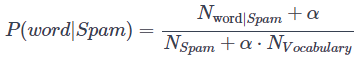

Above is a screenshot of the Naive Bayes formula that will be used for this particular scenario - note the reference to spam. The example shows how to calculate the probability of a word being present given that we already know it is a spam email we are looking at. I will use this along with some intermediate calculations for the classifier.

I define a `classify_email` function below which accepts the following parameters:
- `email` - the input to be classified
- `ham_word_freq` - the frequency dictionary for ham words
- `spam_word_freq` - the frequency dictionary for spam words
- `num_ham` - number of ham emails in training set
- `num_spam` - number of spam emails in training set
- `alpha` - additional parameter used to avoid divison by zero errors, default value is `1` but can be changed

`p_word_given_spam` and `p_word_given_spam` within the function are both calculations of the formula in the image above.

The function returns a prediction of `1` when the `p_spam` is greater than or equal to `p_ham`.

In [ ]:
def classify_email(email, ham_word_freq, spam_word_freq, num_ham, num_spam, alpha=1):
    p_ham = 0
    p_spam = 0
    total_ham_words = sum(ham_word_freq.values())
    total_spam_words = sum(spam_word_freq.values())
    total_unique_words = len(set(list(ham_word_freq.keys()) + list(spam_word_freq.keys())))

    for word in email.split():
        ham_freq = ham_word_freq.get(word, 0)
        spam_freq = spam_word_freq.get(word, 0)
        p_word_given_ham = (ham_freq + alpha) / (total_ham_words + alpha * total_unique_words)
        p_word_given_spam = (spam_freq + alpha) / (total_spam_words + alpha * total_unique_words)
        p_ham += np.log(p_word_given_ham)
        p_spam += np.log(p_word_given_spam)

    p_ham += np.log(num_ham / (num_ham + num_spam))
    p_spam += np.log(num_spam / (num_ham + num_spam))

    if p_spam >= p_ham:
      return 1
    else:
      return 0

Now that the function has been created I will apply it to `test_data` by feeding in the necessary arguments and return the prediction in a new column called `predicted`.

In [ ]:
test_data['predicted'] = test_data['Body'].apply(lambda email: classify_email(email, ham_word_freq, spam_word_freq, len(ham_train), len(spam_train)))

In [ ]:
test_data.head()

,Body,Label,predicted
0,stock promo mover cwtd urgent investor trading...,1,1
3,utf bask life utf individual incremen utf t in...,1,1
10,need medication ideolect hilarious philosophy ...,1,1
11,need vics brand name meds vics vals xanies oth...,1,1
12,urgent security notification dear valuedpaypal...,1,1


I can see that the new column was created successfully and it has been populated.

The next step is to calculate the accuracy of the classifier - what proportion/percentage of predictions were correct. I do this by first creating a boolean comparison called `prediction_correct`.

In [ ]:
prediction_correct = test_data['Label'] == test_data['predicted']

Finally I can use the boolean index against `test_data` to return the rows where the prediction was correct. If I then divide the number of correct rows by the number of total rows, I will find the accuracy.

In [ ]:
accuracy = len(test_data[prediction_correct]) / len(test_data)
print(accuracy)

0.9834796076406814


98% is very high and shows how effective Naive Bayes can be for a scenario like this.

In a production environment, the probabilities could be continually updated based on user feedback, e.g. users manually reporting as ham/spam depending on their own interpretation.

It would also be interesting to try creating a similar classifier for sentiment analysis and seeing how accurate that functions.